# Sea Turtle Image Segmentation and Identification

In [12]:
import os
import torch
import torchvision
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import json
import random
import shutil

In [14]:
# Configuration parameters
NUM_CLASSES = 4  # 3 classes (turtle, flipper, head) + 1 for background
EPOCHS = 10
LEARNING_RATE = 0.005
BATCH_SIZE = 4
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [16]:
# Paths
DATA_DIR = "data/"
IMG_DIR = DATA_DIR
ANN_FILE = os.path.join(DATA_DIR, "annotations.json")

## Prepare Dataset

In [19]:
# Dataset Class
class SeaTurtleDataset(Dataset):
    def __init__(self, img_dir, ann_file, transform=None, split="train", test_size=0.1, random_state=42):
        self.coco = COCO(ann_file)
        self.img_dir = img_dir
        self.img_ids = list(self.coco.imgs.keys())
        
        # Perform train-test split
        train_ids, test_ids = train_test_split(self.img_ids, test_size=test_size, random_state=random_state)
        self.img_ids = train_ids if split == "train" else test_ids
        
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        # Load image
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")
        
        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        
        boxes, masks, labels = [], [], []
        for ann in anns:
            # Bounding boxes
            xmin, ymin, width, height = ann['bbox']
            xmax, ymax = xmin + width, ymin + height
            boxes.append([xmin, ymin, xmax, ymax])
            # Masks
            mask = self.coco.annToMask(ann)
            masks.append(mask)
            # Labels
            labels.append(ann['category_id'])
        
        # Convert data to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # Convert list of numpy arrays to a single numpy array and then to tensor
        masks = np.array(masks)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([img_id]),
            "area": torch.as_tensor([ann['area'] for ann in anns], dtype=torch.float32),
            "iscrowd": torch.as_tensor([ann['iscrowd'] for ann in anns], dtype=torch.int64),
        }
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [21]:
# Define the transforms
def get_transform():
    def transform(image):
        image = F.to_tensor(image)
        return image
    return transform

In [22]:
# Initialize Train and Test Datasets
train_dataset = SeaTurtleDataset(IMG_DIR, ANN_FILE, transform=get_transform(), split="train")
test_dataset = SeaTurtleDataset(IMG_DIR, ANN_FILE, transform=get_transform(), split="test")

# Initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


## Initialize Model

In [23]:
# Load Mask R-CNN model
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, NUM_CLASSES)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, 256, NUM_CLASSES)
model.to(DEVICE)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [24]:
# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)

In [25]:
# Validator
def validate_targets(targets):
    """Validate targets for empty bounding boxes."""
    for target in targets:
        if not isinstance(target['boxes'], torch.Tensor):
            print("Expected target boxes to be a tensor. Skipping this target.")
            return False
        
        if target['boxes'].numel() == 0:
            print("Empty target boxes for an image. Skipping this target.")
            return False
        
        if len(target['boxes'].shape) != 2 or target['boxes'].shape[-1] != 4:
            print(f"Invalid target boxes shape: {target['boxes'].shape}. Expected shape: [N, 4].")
            return False
    
    return True

# Before training, validate the entire dataset
for images, targets in train_loader:
    # Move targets to device if necessary
    targets = [{k: v.to(DEVICE) for k, v in target.items()} for target in targets]
    
    if not validate_targets(targets):
        print("Found invalid targets in the training dataset. Please check your dataset.")
        break  # or handle accordingly

## Training

In [32]:
# Specify the directory to save checkpoints
CHECKPOINT_DIR = "checkpoints/"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Validator function for targets
def validate_and_filter_targets(images, targets):
    """Filter out invalid targets and corresponding images."""
    valid_images = []
    valid_targets = []
    
    for img, target in zip(images, targets):
        if (
            isinstance(target['boxes'], torch.Tensor) and 
            target['boxes'].numel() > 0 and 
            len(target['boxes'].shape) == 2 and 
            target['boxes'].shape[-1] == 4
        ):
            valid_images.append(img)
            valid_targets.append(target)
        else:
            print("Skipping an image due to invalid target boxes.")

    return valid_images, valid_targets

# Save checkpoint function
def save_checkpoint(model, epoch, loss, optimizer, checkpoint_dir=CHECKPOINT_DIR):
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch + 1}.pth")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    print(f"Checkpoint saved successfully at {checkpoint_path}")

# Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        # Move images and targets to the specified device
        images = [image.to(DEVICE) for image in images]
        targets = [{k: v.to(DEVICE) for k, v in target.items()} for target in targets]

        # Validate and filter images and targets
        images, valid_targets = validate_and_filter_targets(images, targets)

        # Skip the batch if no valid targets exist
        if len(valid_targets) == 0:
            print("No valid targets in this batch. Skipping the batch.")
            continue

        # Forward pass
        loss_dict = model(images, valid_targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss}")

    # Save checkpoint for each epoch
    save_checkpoint(model, epoch, avg_loss, optimizer)

# Save the final model
final_model_path = os.path.join(CHECKPOINT_DIR, "sea_turtle_mask_rcnn_final.pth")
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved successfully at {final_model_path}")

Epoch 1/10: 100%|██████████| 196/196 [52:42<00:00, 16.14s/it] 


Epoch 1, Loss: 0.5594757972475217
Checkpoint saved successfully at checkpoints/checkpoint_epoch_1.pth


Epoch 2/10: 100%|██████████| 196/196 [47:21<00:00, 14.50s/it]


Epoch 2, Loss: 0.2729635294146684
Checkpoint saved successfully at checkpoints/checkpoint_epoch_2.pth


Epoch 3/10: 100%|██████████| 196/196 [48:00<00:00, 14.70s/it]


Epoch 3, Loss: 0.21947749939804173
Checkpoint saved successfully at checkpoints/checkpoint_epoch_3.pth


Epoch 4/10: 100%|██████████| 196/196 [50:27<00:00, 15.45s/it] 


Epoch 4, Loss: 0.1923195908264238
Checkpoint saved successfully at checkpoints/checkpoint_epoch_4.pth


Epoch 5/10: 100%|██████████| 196/196 [50:54<00:00, 15.59s/it] 


Epoch 5, Loss: 0.17332355560240698
Checkpoint saved successfully at checkpoints/checkpoint_epoch_5.pth


Epoch 6/10: 100%|██████████| 196/196 [50:39<00:00, 15.51s/it]


Epoch 6, Loss: 0.15820502151488042
Checkpoint saved successfully at checkpoints/checkpoint_epoch_6.pth


Epoch 7/10: 100%|██████████| 196/196 [51:42<00:00, 15.83s/it]


Epoch 7, Loss: 0.1481705272228134
Checkpoint saved successfully at checkpoints/checkpoint_epoch_7.pth


Epoch 8/10: 100%|██████████| 196/196 [49:29<00:00, 15.15s/it] 


Epoch 8, Loss: 0.1397412602922746
Checkpoint saved successfully at checkpoints/checkpoint_epoch_8.pth


Epoch 9/10: 100%|██████████| 196/196 [49:16<00:00, 15.08s/it]


Epoch 9, Loss: 0.1323639403800575
Checkpoint saved successfully at checkpoints/checkpoint_epoch_9.pth


Epoch 10/10: 100%|██████████| 196/196 [50:07<00:00, 15.34s/it]


Epoch 10, Loss: 0.12720119455183038
Checkpoint saved successfully at checkpoints/checkpoint_epoch_10.pth
Final model saved successfully at checkpoints/sea_turtle_mask_rcnn_final.pth


## Evaluation

In [197]:
# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    results = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            results.extend(outputs)
    return results

# Evaluate the model on the test set
test_results = evaluate(model, test_loader, DEVICE)

torch.save(test_results, "test_results.pt")

print("test_results saved as test_results.pt")

test_results saved as test_results.pt


In [217]:
# Load test_results.pt
loaded_test_results = torch.load("test_results.pt")
test_results = loaded_test_results
print("Loaded test results")

C:\Users\cando\AppData\Local\Temp\ipykernel_153304\3549671985.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_test_results = torch.load("test_results.pt")


Loaded test results


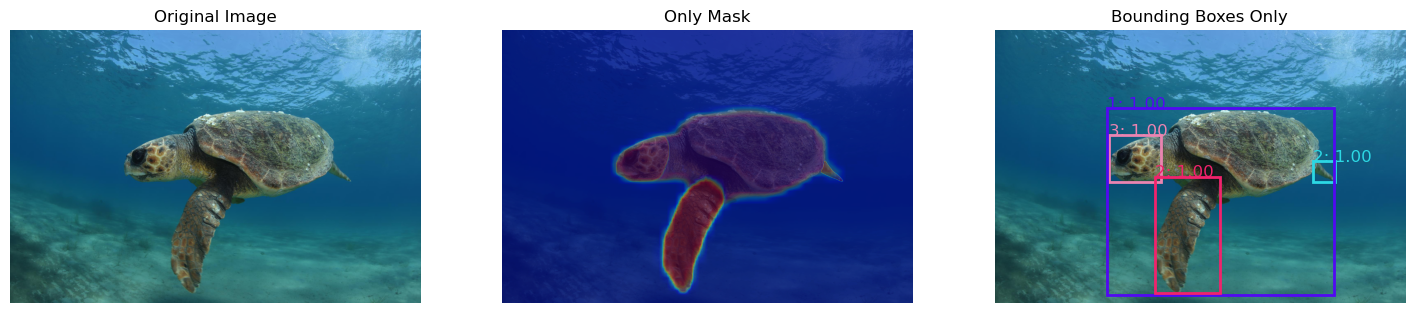

In [225]:
# Visualize predictions using test_results
import matplotlib.pyplot as plt
import random

def visualize_prediction(image, boxes, masks, labels, scores, threshold=0.5):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure with three subplots

    # Original Image
    ax[0].imshow(image.permute(1, 2, 0).cpu())
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    # Only Mask Image
    ax[1].imshow(image.permute(1, 2, 0).cpu())  # Background image to keep original size
    for i in range(len(masks)):
        if scores[i] > threshold:
            ax[1].imshow(masks[i].squeeze(0).cpu(), cmap='jet', alpha=0.25)
    ax[1].set_title("Only Mask")
    ax[1].axis("off")
    
    # Only Bounding Boxes on the Original Image
    ax[2].imshow(image.permute(1, 2, 0).cpu())  # Background image
    for i in range(len(boxes)):
        if scores[i] > threshold:
            # Random color for visualization
            color = (random.random(), random.random(), random.random())
            # Draw bounding box
            x_min, y_min, x_max, y_max = boxes[i]
            ax[2].add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          fill=False, color=color, linewidth=2))
            # Add label with score
            ax[2].text(x_min, y_min, f"{labels[i]}: {scores[i]:.2f}", color=color, fontsize=12)
                
    ax[2].set_title("Bounding Boxes Only")
    ax[2].axis("off")
    plt.show()

# Choose a random index to visualize from the entire dataset
random_index = random.randint(0, len(test_loader.dataset) - 1)

# Extract the prediction and corresponding image and target for the random index
sample_img, sample_target = test_loader.dataset[random_index]  # Access dataset directly
sample_img = sample_img  # Image at `random_index`

# Extract prediction from `test_results`
pred = test_results[random_index]

# Visualization with original, mask-only, and bounding box-only images
visualize_prediction(
    sample_img.cpu(), 
    pred['boxes'].cpu(), 
    pred['masks'].cpu(), 
    pred['labels'], 
    pred['scores'].cpu()
)

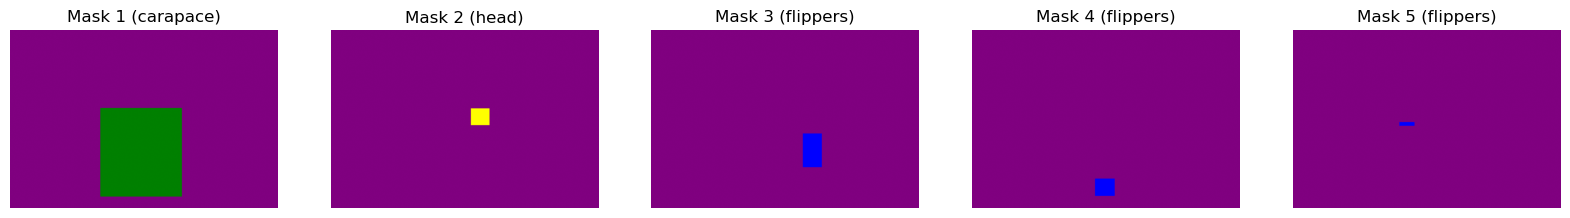

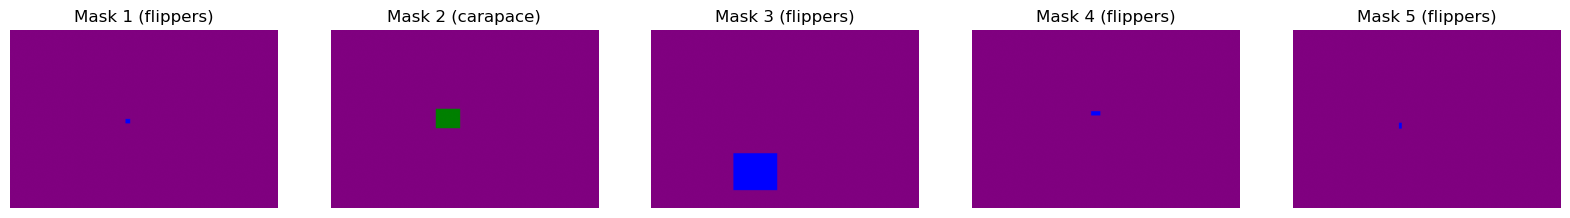

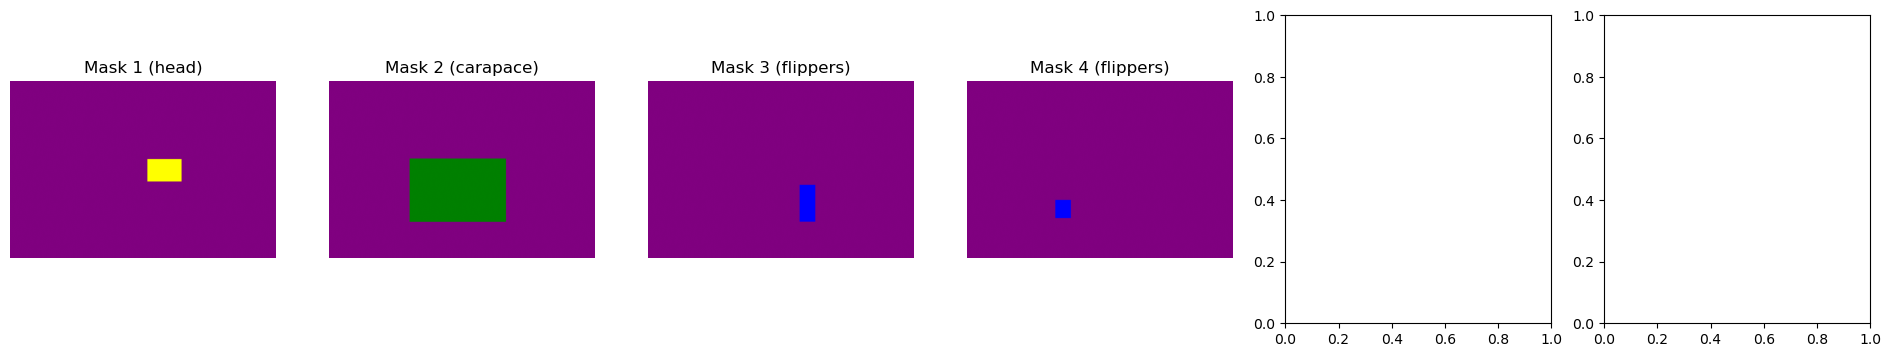

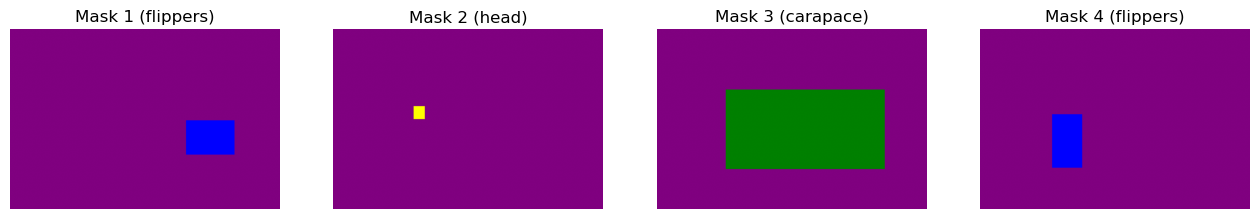

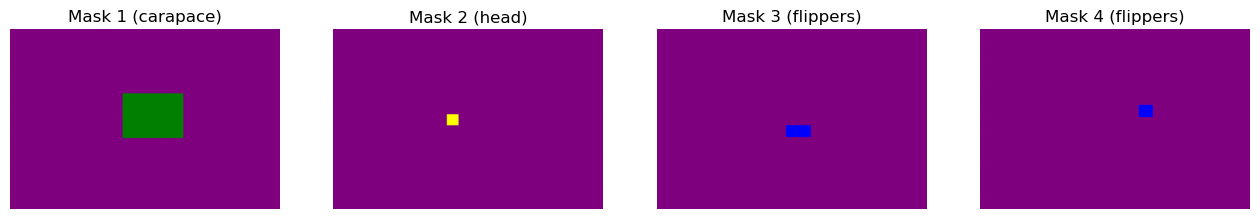

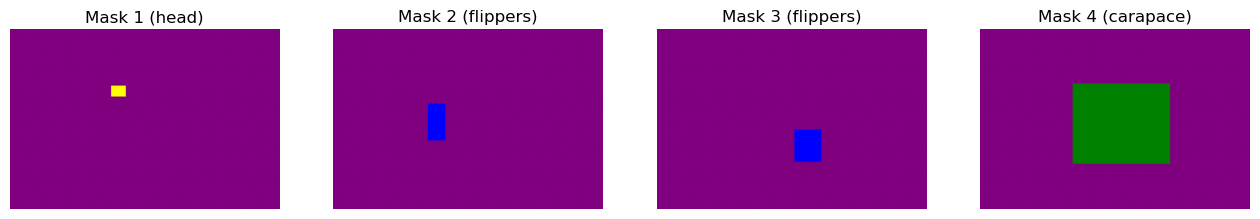

In [193]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Define color map for each category
VOC_COLORMAP = {
    "background": [128/255, 0, 128/255],  # purple
    "head": [1, 1, 0],                    # yellow
    "carapace": [0, 128/255, 0],          # green
    "flippers": [0, 0, 1]                 # blue
}

# Map labels to category names
CATEGORY_NAMES = {1: "carapace", 2: "flippers", 3: "head"}  # Example label mapping

def visualize_separate_masks(image, masks, labels, scores, threshold=0.5):
    num_masks = len(masks)
    fig, ax = plt.subplots(1, num_masks, figsize=(num_masks * 4, 4))  # Create a subplot for each mask

    for i in range(num_masks):
        if scores[i] > threshold:
            label_name = CATEGORY_NAMES.get(labels[i].item(), "background")
            color = VOC_COLORMAP[label_name]  # Get color for the category
            
            # Initialize an image with the background color
            mask_image = np.ones((masks[i].shape[1], masks[i].shape[2], 3)) * VOC_COLORMAP["background"]
            
            # Extract mask and apply color
            mask = masks[i].squeeze(0).cpu().numpy().astype(bool)
            for j in range(3):  # Apply color to each channel in the mask region
                mask_image[..., j] = np.where(mask, color[j], mask_image[..., j])
            
            # Display the individual mask
            ax[i].imshow(mask_image)
            ax[i].set_title(f"Mask {i + 1} ({label_name})")
            ax[i].axis("off")

    plt.show()

# Visualize six random predictions with only separate masks
for _ in range(6):
    # Choose a random index to visualize from the entire dataset
    random_index = random.randint(0, len(test_loader.dataset) - 1)

    # Extract the prediction and corresponding image and target for the random index
    sample_img, sample_target = test_loader.dataset[random_index]  # Access dataset directly

    # Extract prediction from `test_results`
    pred = test_results[random_index]

    # Visualization with only separate masks
    visualize_separate_masks(
        sample_img.cpu(),
        pred['masks'].cpu(),
        pred['labels'],
        pred['scores'].cpu()
    )

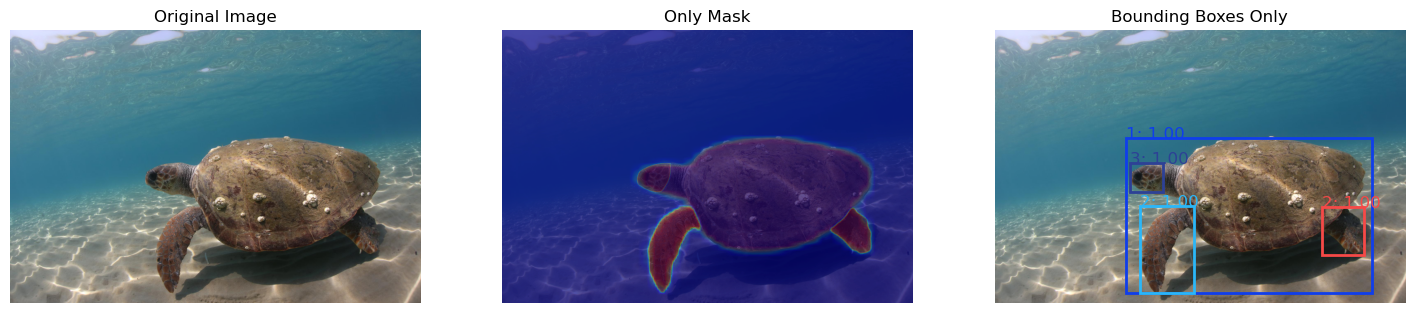

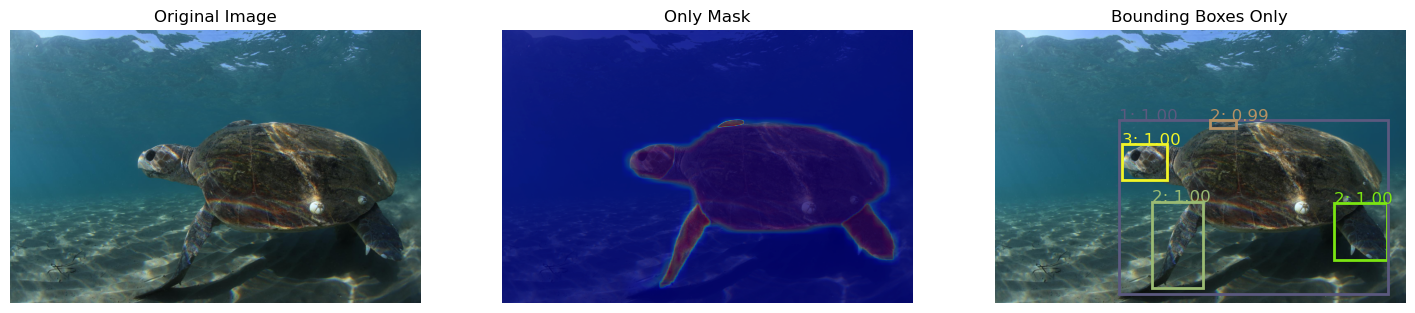

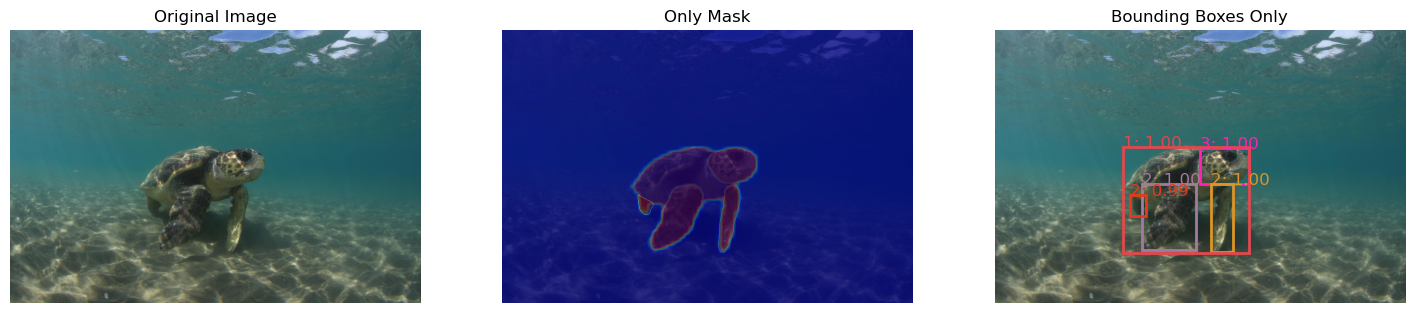

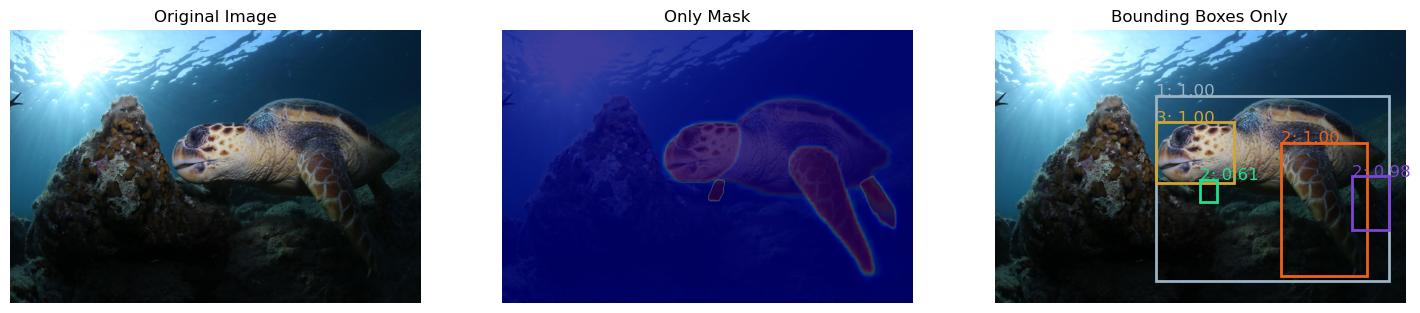

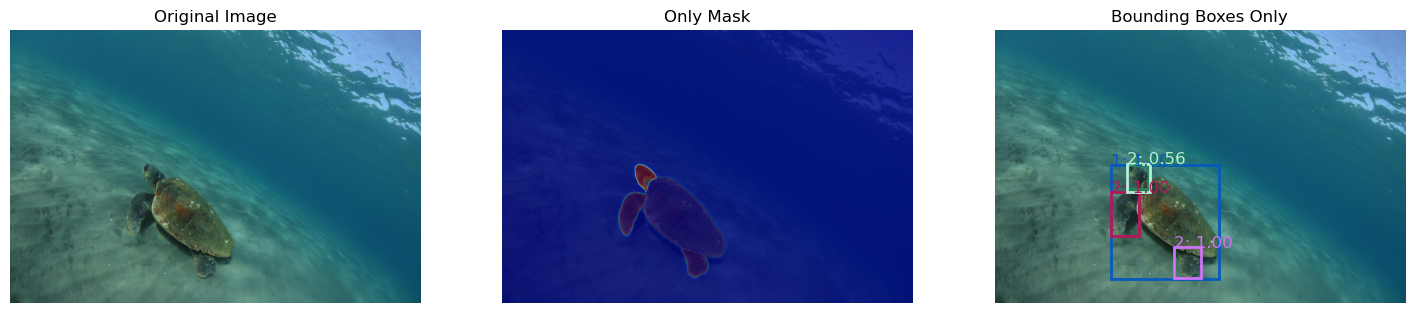

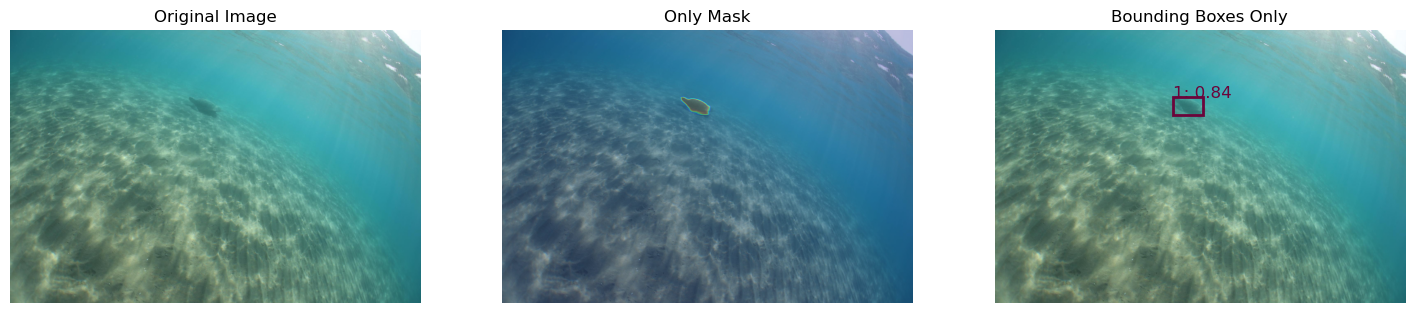

In [221]:
# Visualize 6 predictions using test_results
import matplotlib.pyplot as plt
import random

def visualize_prediction(image, boxes, masks, labels, scores, threshold=0.5):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure with three subplots

    # Original Image
    ax[0].imshow(image.permute(1, 2, 0).cpu())
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    # Only Mask Image
    ax[1].imshow(image.permute(1, 2, 0).cpu())  # Background image to keep original size
    for i in range(len(masks)):
        if scores[i] > threshold:
            ax[1].imshow(masks[i].squeeze(0).cpu(), cmap='jet', alpha=0.25)
    ax[1].set_title("Only Mask")
    ax[1].axis("off")
    
    # Only Bounding Boxes on the Original Image
    ax[2].imshow(image.permute(1, 2, 0).cpu())  # Background image
    for i in range(len(boxes)):
        if scores[i] > threshold:
            # Random color for visualization
            color = (random.random(), random.random(), random.random())
            # Draw bounding box
            x_min, y_min, x_max, y_max = boxes[i]
            ax[2].add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          fill=False, color=color, linewidth=2))
            # Add label with score
            ax[2].text(x_min, y_min, f"{labels[i]}: {scores[i]:.2f}", color=color, fontsize=12)
                
    ax[2].set_title("Bounding Boxes Only")
    ax[2].axis("off")
    plt.show()

# Visualize six random predictions
for _ in range(6):
    # Choose a random index to visualize from the entire dataset
    random_index = random.randint(0, len(test_loader.dataset) - 1)

    # Extract the prediction and corresponding image and target for the random index
    sample_img, sample_target = test_loader.dataset[random_index]  # Access dataset directly

    # Extract prediction from `test_results`
    pred = test_results[random_index]

    # Visualization with original, mask-only, and bounding box-only images
    visualize_prediction(
        sample_img.cpu(), 
        pred['boxes'].cpu(), 
        pred['masks'].cpu(), 
        pred['labels'], 
        pred['scores'].cpu()
    )

In [211]:
# IoU Calculation
# Calculate IoU for undetected areas
def calculate_iou(pred_mask, true_mask):
    """Calculate the Intersection over Union (IoU) score."""
    intersection = torch.logical_and(pred_mask, true_mask).sum().item()
    union = torch.logical_or(pred_mask, true_mask).sum().item()
    return intersection / union if union != 0 else 0

# Example categories for segmentation
CATEGORIES = ["head", "flippers", "carapace"]

# Define label mappings for each category
CATEGORY_LABELS = {
    "head": 3,
    "flippers": 2,
    "carapace": 1
}

# Calculate mIoU for each category over the test set
iou_scores = {category: [] for category in CATEGORIES}
iou_scores["background"] = []  # Add a list for background IoU

model.eval()
with torch.no_grad():
    for sample in test_dataset:
        # Sample image and ground-truth target
        image, target = sample
        image = image.to(DEVICE)
        
        # Forward pass
        pred = model([image])[0]

        # Move predictions and ground truth to CPU for evaluation
        pred_masks = pred['masks']
        true_masks = target['masks']

        # Create a combined mask for all detected areas
        detected_area = torch.zeros_like(pred_masks[0], dtype=torch.bool, device=DEVICE)  # Ensure it is on the same device
        for category in CATEGORIES:
            category_label = CATEGORY_LABELS[category]
            pred_mask = pred_masks[pred['labels'] == category_label]
            if pred_mask.shape[0] > 0:  # If there are predictions for this category
                detected_area |= pred_mask.any(dim=0)  # Union of detected masks

        # Calculate IoU for each category
        for category in CATEGORIES:
            category_label = CATEGORY_LABELS[category]
            true_mask = target['masks'][target['labels'] == category_label].squeeze(0) if (target['labels'] == category_label).any() else None
            
            if true_mask is not None:
                pred_mask = pred_masks[pred['labels'] == category_label].squeeze(0) if (pred['labels'] == category_label).any() else None
                if pred_mask is not None:
                    iou = calculate_iou(pred_mask.cpu(), true_mask.cpu())
                    iou_scores[category].append(iou)

        # Calculate background IoU based on the undetected areas
        true_background_mask = (true_masks.sum(dim=0) == 0).to(DEVICE)  # Move to the same device
        pred_background_mask = (~detected_area).to(DEVICE)  # Move to the same device
        bg_iou = calculate_iou(pred_background_mask, true_background_mask)
        iou_scores["background"].append(bg_iou)

# Calculate mean IoU (mIoU) for each category
mean_iou_scores = {category: np.mean(iou_scores[category]) for category in iou_scores}

# Print average metrics
print("Average Metrics:")
for category, score in mean_iou_scores.items():
    print(f"{category.capitalize()} IoU: {score:.3f}")

Average Metrics:
Head IoU: 0.611
Flippers IoU: 0.145
Carapace IoU: 0.442
Background IoU: 0.810
